<a href="https://colab.research.google.com/github/netphoenix/ds_belhard/blob/main/hw4/ds_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя работа №4 «Data Science начальный уровень»

**Author**: Скробат Александр (tg @FlamePhnx)

Реализовать минимум 5 классификаторов, сравнить метрики между собой, выбрать лучший для Вашего датасета.
Классификаторы:
* Классификатор градиентного бустинга.
* Классификатор CatBoost.
* Классификатор Ada Boost.
* Классификатор Extra Trees.
* Квадратичный дискриминантный анализ.
* Light Gradient Boosting Machine.
* Классификатор K Neighbors.
* Классификатор дерева решений.
* Экстремальный градиентный бустинг.
* Фиктивный классификатор.  
* SVM - линейное ядро.

Обучите модель на наборе данных Credit Card Fraud Detection для предсказания мошеннических транзакций. Проведите гиперпараметрическую настройку и оцените результаты.

In [ ]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

# Классификатор CatBoost.
!pip install catboost

# Модели
from sklearn.linear_model import LogisticRegression # Для сравнения
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Метрики и утилиты
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score, # AUPRC - ключевая метрика
    confusion_matrix,
    classification_report
)

# Борьба с дисбалансом
from imblearn.over_sampling import SMOTE

# Глобальные настройки визуализаций
sns.set_theme(
    style="whitegrid",       # стиль: сетка на белом фоне
    context="paper",         # размер элементов (можно: paper, talk, poster, notebook)
    palette="pastel"         # базовая цветовая палитра --viridis
)

plt.rcParams["figure.figsize"] = (4, 3)   # дефолтный размер графиков
plt.rcParams["axes.titlesize"] = 12       # размер заголовков
plt.rcParams["axes.labelsize"] = 10       # размер подписей осей
plt.rcParams["xtick.labelsize"] = 8       # размер подписей по X
plt.rcParams["ytick.labelsize"] = 8       # размер подписей по Y

# Глобальные настройки форматирования
pd.set_option('display.max_colwidth', 100)

In [ ]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data
# Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
# В этом наборе данных представлены транзакции, которые произошли за два дня, 492 мошенничества из 284 807 транзакций. Датасет сильно разбалансирован, на позитивный класс (фроды) приходится 0,172% всех транзакций.
# Cодержит только числовые переменные, которые являются результатом преобразования PCA (Principal Component Analysis, метод главных компонент).
# Признаки V1, V2, ... V28 являются основными компонентами, полученными с помощью PCA, единственными признаками, которые не были преобразованы, являются 'Time' и 'Amount'.
# Признак 'Time' содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных.
# Признак 'Amount' - это сумма транзакции, может быть использована, например, для обучения, зависящего от стоимости.
# Признак 'Class' является принимает значение 1 в случае мошенничества и 0 в противном случае.
# Учитывая коэффициент дисбаланса классов, рекомендуется измерять точность с помощью метрики Площадь под кривой Precision-Recall (AUPRC).
# Она хорошо отражает соотношение между точностью (precision) и полнотой (recall), важными при работе с неравномерным распределением классов.

import kagglehub
import subprocess

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)
# !ls {path}

# Выполняем команду ls и получаем список файлов в path
result = subprocess.run(['ls', path], stdout=subprocess.PIPE, text=True)
# Вывод результата в переменную в виде строки
files_list = result.stdout.strip()
print("Файлы в папке:", files_list)
file_path = f"{path}/{files_list}"
print(file_path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud
Файлы в папке: creditcard.csv
/kaggle/input/creditcardfraud/creditcard.csv


In [ ]:
data_df = pd.read_csv(file_path)
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


In [ ]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# Проверим, есть ли пропущенные данные

total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Количество объектов в каждом классе:
Class
0    284315
1       492
Name: count, dtype: int64

Доля мошеннических транзакций: 0.1727%


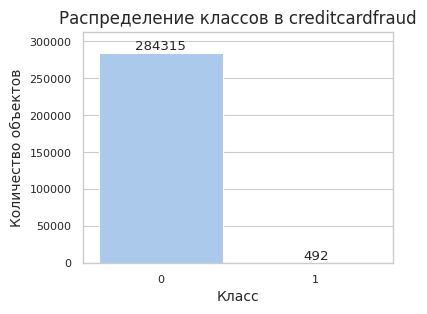

In [ ]:
# Проверим дисбаланс данных в отношении целевого значения

# Подсчёт количества объектов в 'Class'
class_counts = data_df['Class'].value_counts()

print("Количество объектов в каждом классе:")
print(class_counts)

# Доля мошеннических транзакций
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(f"\nДоля мошеннических транзакций: {fraud_percentage:.4f}%")

# Построение графика с подписью количества над столбцами
# ax = sns.countplot(x='Class', data=data_df, palette=['#3498db', '#e74c3c'])
ax = sns.countplot(x='Class', data=data_df)

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.title('Распределение классов в creditcardfraud')
plt.xlabel('Класс')
plt.ylabel('Количество объектов')
plt.ylim(0, class_counts.max() * 1.1)  # небольшой отступ сверху для подписей
plt.show()


In [ ]:
# Для следующих моделей масштабирование обязательно или сильно рекомендуется:
# SVM (особенно с линейным ядром) — чувствителен к масштабу данных
# KNeighborsClassifier (KNN) — зависит от расстояний между точками, масштабирование обязательно
# Логистическая регрессия (LogisticRegression) — требует стандартизации
# QDA (Quadratic Discriminant Analysis) — для корректной оценки ковариационных матриц предпочтительно масштабирование

# Масштабирование признаков 'Amount' и 'Time' с использованием StandardScaler
scaler = StandardScaler()

data_df['scaled_amount'] = scaler.fit_transform(data_df['Amount'].values.reshape(-1, 1))
data_df['scaled_time'] = scaler.fit_transform(data_df['Time'].values.reshape(-1, 1))

# Удаляем оригинальные столбцы
data_df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Теперь data_df содержит скалированные признаки Time_scaled и Amount_scaled
data_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


In [ ]:
# Определение признаков и целевой переменной
X = data_df.drop('Class', axis=1)
y = data_df['Class']

# Разделение на обучающую и тестовую выборки
# Используем stratify=y, чтобы сохранить пропорцию классов в обеих выборках
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (227845, 30)
Размер тестовой выборки: (56962, 30)


In [ ]:
# scale_pos_weight: для XGBoost, LightGBM. Отношение числа отрицательных примеров к числу положительных

# Расчет веса для положительного класса
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"Scale_pos_weight: {scale_pos_weight_value:.2f}")

classifiers = {
    "Фиктивный (Dummy)": DummyClassifier(strategy='most_frequent'),
    "SVM - линейное ядро": LinearSVC(dual=False, class_weight='balanced', random_state=42, max_iter=2000),
    "K-Neighbors (KNN)": KNeighborsClassifier(n_jobs=-1),  # поддерживает многопоточность
    "Дерево решений": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    # "Градиентный бустинг": GradientBoostingClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    "Квадр. дискрим. анализ (QDA)": QuadraticDiscriminantAnalysis(),
    "XGBoost": xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight_value,
        eval_metric='logloss',
        random_state=42,
        tree_method='hist',
        device='cuda',        # Указание устройств CUDA для GPU
        n_jobs=-1
    ),
    "LightGBM": lgb.LGBMClassifier(
        objective='binary',
        scale_pos_weight=scale_pos_weight_value,
        random_state=42,
        device='gpu',
        n_jobs=-1
    ),
    "CatBoost": cb.CatBoostClassifier(
        auto_class_weights='Balanced',
        verbose=0,
        random_state=42,
        task_type='GPU',
        thread_count=-1  # в CatBoost для многопоточности используется thread_count
    )
}

# Словарь с классификаторами
# classifiers = {
#     "Фиктивный (Dummy)": DummyClassifier(strategy='most_frequent'),
#     # "SVM - линейное ядро": SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
#     "SVM - линейное ядро": LinearSVC(dual=False, class_weight='balanced', random_state=42, max_iter=2000),
#     "K-Neighbors (KNN)": KNeighborsClassifier(),
#     "Дерево решений": DecisionTreeClassifier(class_weight='balanced', random_state=42),
#     "AdaBoost": AdaBoostClassifier(random_state=42),
#     "Градиентный бустинг": GradientBoostingClassifier(random_state=42),
#     "Extra Trees": ExtraTreesClassifier(class_weight='balanced', random_state=42),
#     "Квадр. дискрим. анализ (QDA)": QuadraticDiscriminantAnalysis(),
#     "XGBoost": xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight_value, use_label_encoder=False, eval_metric='logloss', random_state=42),
#     "LightGBM": lgb.LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_value, random_state=42),
#     "CatBoost": cb.CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42)
# }

# Обучение и оценка моделей
results = []
for name, clf in classifiers.items():
    print(f"--- Обучение {name}")
    start_time = time()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else [0.5] * len(y_test)

    end_time = time()

    results.append({
        "Модель": name,
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "F1-score": f1_score(y_test, y_pred),
        "AUPRC": average_precision_score(y_test, y_proba), # Area Under PR Curve
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Время (сек)": end_time - start_time
    })

# Преобразование результатов в DataFrame для удобного просмотра
results_df = pd.DataFrame(results).sort_values(by='AUPRC', ascending=False).reset_index(drop=True)

print("\n--- Результаты сравнения моделей ---")
print(results_df)

In [ ]:
results_df

,Модель,Recall,Precision,F1-score,AUPRC,ROC AUC,Время (сек)
0,XGBoost,0.846939,0.882979,0.864583,0.877254,0.968626,0.701525
1,Extra Trees,0.785714,0.950617,0.860335,0.873921,0.952773,3.252238
2,CatBoost,0.857143,0.807692,0.831683,0.865906,0.974154,5.007936
3,K-Neighbors (KNN),0.806122,0.918605,0.858696,0.843362,0.943756,25.462969
4,AdaBoost,0.755102,0.718447,0.736318,0.694569,0.976705,84.827206
5,Дерево решений,0.714286,0.707071,0.710660,0.505542,0.856888,12.488847
6,Градиентный бустинг,0.183673,0.529412,0.272727,0.156654,0.346886,470.501560
7,Квадр. дискрим. анализ (QDA),0.877551,0.059107,0.110753,0.143094,0.965692,0.468381
8,LightGBM,0.877551,0.038756,0.074234,0.036306,0.900109,5.895107
9,SVM - линейное ядро,0.918367,0.071542,0.132743,0.001720,0.500000,2.535946


In [ ]:
# # Pipeline с масштабированием и SVM с balanced class weight
# svm_linear = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)

# start_time = time()

# # Обучение
# svm_linear.fit(X_train, y_train)
# print("Training time (seconds):", time() - start_time)

# # Предсказание
# y_pred = svm_linear.predict(X_test)
# y_prob = svm_linear.predict_proba(X_test)[:, 1]

# end_time = time()

# # Отчёт по метрикам классификации
# print(classification_report(y_test, y_pred))

# # ROC AUC
# print('ROC AUC:', roc_auc_score(y_test, y_prob))

# print('Recall: ', recall_score(y_test, y_pred))

#         # "Precision": precision_score(y_test, y_pred, zero_division=0),
#         # "F1-score": f1_score(y_test, y_pred),
#         # "AUPRC": average_precision_score(y_test, y_proba), # Area Under PR Curve
#         # "ROC AUC": roc_auc_score(y_test, y_proba),
#         # "Время (сек)": end_time - start_time

In [ ]:
# Применим SMOTE (Synthetic Minority Over-sampling Technique) для генерации синтетических примеров мошеннических транзакций в обучающей выборке.
# Важно: SMOTE применяется только к обучающим данным (X_train, y_train). Тестовая выборка должна оставаться в первозданном виде.

print("Классы до SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Классы после SMOTE:", y_train_resampled.value_counts())

# Повторное обучение на сбалансированных данных
results_list_smote = []

for name, clf in classifiers.items():
    print(f"Обучение {name} на данных SMOTE...")
    start_time = time()

    # Обучаем на сбалансированных данных
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else [0.5] * len(y_test)

    end_time = time()

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    results_list_smote.append({
        'Model': name,
        'Recall (1)': round(report['1']['recall'], 4),
        'Precision (1)': round(report['1']['precision'], 4),
        'F1-score (1)': round(report['1']['f1-score'], 4),
        'AUPRC': round(average_precision_score(y_test, y_proba), 4),
        'ROC AUC': round(roc_auc_score(y_test, y_proba), 4),
        'Time (s)': round(end_time - start_time, 2)
    })

results_df_after = pd.DataFrame(results_list_smote).sort_values(by='F1-score (1)', ascending=False)
print("\n--- Результаты после применения SMOTE ---")
print(results_df_after)

Классы до SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
Классы после SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64
Обучение Фиктивный (Dummy) на данных SMOTE...
Обучение SVM - линейное ядро на данных SMOTE...
Обучение K-Neighbors (KNN) на данных SMOTE...
Обучение Дерево решений на данных SMOTE...
Обучение AdaBoost на данных SMOTE...
Обучение Градиентный бустинг на данных SMOTE...
Обучение Extra Trees на данных SMOTE...
Обучение Квадр. дискрим. анализ (QDA) на данных SMOTE...
Обучение XGBoost на данных SMOTE...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:53:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:53:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [19:53:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


Обучение LightGBM на данных SMOTE...
[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] Using GPU Device: NVIDIA A100-SXM4-40GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (13.88 MB) transferred to GPU in 0.018528 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Обучение CatBoost на данных SMOTE...

--- Результаты после применения SMOTE ---
                           Model  Time (s)  ROC AUC  Avg Precision  \
6                    Extra Trees      7.69   0.9782         0.8809   
10                      CatBoost      5.01   0.9800         0.85

In [ ]:
results_df_after

,Model,Time (s),ROC AUC,Avg Precision,Recall (1),Precision (1),F1-score (1)
6,Extra Trees,7.69,0.9782,0.8809,0.8469,0.9222,0.8830
10,CatBoost,5.01,0.9800,0.8594,0.8878,0.5241,0.6591
2,K-Neighbors (KNN),53.93,0.9536,0.6333,0.8776,0.4649,0.6078
8,XGBoost,0.87,0.9783,0.8462,0.8571,0.4641,0.6022
3,Дерево решений,57.51,0.8865,0.2635,0.7755,0.3393,0.4720
5,Градиентный бустинг,985.67,0.9807,0.6885,0.8980,0.1055,0.1888
9,LightGBM,1.81,0.9767,0.7429,0.9082,0.0829,0.1520
1,SVM - линейное ядро,3.18,0.5000,0.0017,0.9082,0.0644,0.1203
7,Квадр. дискрим. анализ (QDA),0.85,0.9587,0.1661,0.8878,0.0541,0.1021
4,AdaBoost,177.43,0.9734,0.7976,0.9082,0.0418,0.0799


In [ ]:
# Выберем LightGBM для дальнейшей настройки, так как он показывает хорошие результаты при очень высокой скорости обучения
# Используем RandomizedSearchCV для быстрого поиска хороших параметров

# Определяем сетку параметров для LightGBM
lgbm_params = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'colsample_bytree': [0.7, 0.9, 1.0],
}

lgbm = lgb.LGBMClassifier(objective='binary', random_state=42)

# Используем RandomizedSearchCV
# scoring='average_precision' - отличная метрика для этой задачи
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_params,
    n_iter=20, # Количество итераций поиска
    scoring='average_precision',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("\n--- Настройка гиперпараметров для LightGBM ---")
# Обучаем на сбалансированных данных
random_search.fit(X_train_resampled, y_train_resampled)

print("\nЛучшие параметры:", random_search.best_params_)
print("Лучший Average Precision на CV:", random_search.best_score_)

# Сохраняем лучшую модель
best_lgbm = random_search.best_estimator_




--- Настройка гиперпараметров для LightGBM ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
